In [1]:
# !pip install cartopy
# !pip install matplotlib
# !pip install numpy
# !pip install onc
# !pip install pandas
# !pip install xarray

In [2]:
import cartopy.crs as ccrs
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from netrc import netrc
import numpy as np
from os import PathLike
import pandas as pd
import xarray as xr

from onc import ONC

## Helper Functions

In [3]:
def dt2str(dt: datetime) -> str:
    """
    Convert a Pythonic datetime object to a string that is compatible with the ONC Oceans 3.0 API dateFrom and dateTo
    API query parameters.

    :param dt: A Python datetime object.
    ;return: An ISO8601 formatted string representing the datetime.
    """

    dtstr = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'
    return dtstr


def get_onc_token(netrc_path: PathLike | None = None) -> str:
    """
    Retrieve an ONC token from the password portion of a .netrc file entry.

        machine data.oceannetworks.ca
        login <username>
        password <onc_token>

    :param netrc_path: The path to the .netrc file.
        If None, the netrc module looks for a .netrc file in the user directory.
    :return: The ONC token as a string. DO NOT SHARE OR PRINT THIS TOKEN.
    """

    if netrc_path is None:
        _, __, onc_token = netrc().authenticators("data.oceannetworks.ca")
    else:
        _, __, onc_token = netrc(netrc_path).authenticators("data.oceannetworks.ca")
    return onc_token


def _json2xr(json_data: dict) -> xr.Dataset:
    """
    Convert a JSON response from an ONC getScalardata API call to an Xarray dataset.
    
    :param json_data: The JSON response from an ONC getScalardata API call.
    :return: An Xarray dataset.
    """
    dev_cat_code = json_data['metadata']['deviceCategoryCode']
    sensor_data = json_data['sensorData']
    vds_list = []
    for var_data in sensor_data:
        var_name = var_data['sensorName'].replace(' ', '_').lower()
        var_units = var_data['unitOfMeasure']
        var_times = var_data['data']['sampleTimes']
        var_values = var_data['data']['values']
        var_flags = var_data['data']['qaqcFlags']

        # Estimate a dtype based on the last value. This only really matters when trying to store vast amounts of data in a netCDF.
        valstr = str(var_values[-1])
        if '.' in valstr:
            integer_part, decimal_part = valstr.split('.')
            if len(integer_part) + len(decimal_part) <= 7:
                var_dtype = 'float32'
            elif 1 <= len(integer_part) <= 3:
                var_dtype = 'float32'
            else:
                var_dtype = 'float64'
        elif 'e' in valstr:
            var_dtype = 'float64'
        else:
            if len(valstr) <= 7:
                var_dtype = 'int32'
            else:
                var_dtype = 'int64'

        vds = xr.Dataset()
        vds = vds.assign_coords({'time': pd.to_datetime(var_times).tz_localize(None)})
        vds[var_name] = (('time'), var_values)
        vds[var_name].attrs['units'] = var_units
        vds[f"flag_{var_name}"] = (('time'), var_flags)
        vds[f"flag_{var_name}"] = vds[f"flag_{var_name}"].fillna(0)

        # Convert dtypes.
        vds['time'] = vds['time'].astype('datetime64[ms]')
        vds[var_name] = vds[var_name].astype(var_dtype)
        vds[f"flag_{var_name}"] = vds[f"flag_{var_name}"].astype('int8')

        # Assign attributes.
        vds[var_name].attrs['propertyCode'] = var_data['propertyCode']
        vds[var_name].attrs['sensorCategoryCode'] = var_data['sensorCategoryCode']
        vds[var_name].attrs['sensorName'] = var_data['sensorName']
        vds[var_name].attrs['sensorCode'] = var_data['sensorCode']
        vds[var_name].attrs['deviceCategoryCode'] = dev_cat_code
        vds_list.append(vds)

    ds = xr.combine_by_coords(vds_list, combine_attrs='drop_conflicts',join = 'outer')
    ds = ds[sorted(ds.data_vars)]
    return ds


def get_data(ferry: str, device_category: str, begin: datetime, end: datetime, quality: str ='raw'):
    """
    Retrieve scalar data from the ONC Oceans 3.0 API for a given ferry and device category.
    
    :param ferry: The locationCode for the ferry.
    :param device_category: The deviceCategoryCode for the data to retrieve (e.g., 'NAV', 'TSG', 'PVCS').
    :param begin: The beginning datetime for the data retrieval.
    :param end: The ending datetime for the data retrieval.
    :param quality: The quality control level (cleanliness) of the data to retrieve. Default is 'raw'.
    :return: An Xarray dataset containing the requested data.
    """
    params = {'locationCode': ferry, 
          'deviceCategoryCode': device_category,
          'dateFrom': dt2str(begin),
          'dateTo': dt2str(end),
          'qualityControl': quality,
          'fillGaps': False,
          'metadata': 'Full',
          'outputFormat': 'Array'}    
    json_data = onc.getScalardata(params, allPages=True)
    ds = _json2xr(json_data)
    return ds


def get_nav(ferry: str, begin: datetime, end: datetime, quality: str ='raw'):
    """
    Retrieve navigation data from the ONC Oceans 3.0 API for a given ferry. This function will attempt to retrieve data
    from several .* locationCodes, if they exist for a ferry.
    
    :param ferry: The locationCode for the ferry.
    :param begin: The beginning datetime for the data retrieval.
    :param end: The ending datetime for the data retrieval.
    :param quality: The quality control level (cleanliness) of the data to retrieve. Default is 'raw'.
    :return: An Xarray dataset containing the navigation data.
    """
    attempts = [ferry] + ['.'.join((ferry, f'N{i}')) for i in range(1,4)]
    for attempt in attempts:
        try:
            ds = get_data(attempt,'NAV', begin, end, quality)
            return ds
        except Exception as e:
            continue
            
            
def split_transits(data: xr.Dataset, separation_time: int = 60 * 5) -> list[xr.Dataset]:
    """
    Split a ferry time-series dataset into individual transits based on a stoppage period at port. Prior to running
        this function, data at ferry port stops needs to either be masked and removed by bounding box or system/valve
        state.

    :param data: The input dataset. This dataset should be a merged dataset.
    :param separation_time: The time in seconds that defines a stoppage period at port.
    :return: A list of Xarray datasets, each representing an individual transit.
    """

    # First sort the data by time if it isn't already sorted.
    data = data.sortby('time')

    # Identify periods of time where data are separated by more than `separation_time` seconds.
    dts = list(data.where(data['time'].diff('time') > np.timedelta64(separation_time, 's'), drop=True).get_index('time'))

    transits = []
    for dt in dts:
        if dt == dts[-1]:
            start = dt
            stop = None
        else:
            dtidx = dts.index(dt)
            start = dt
            stop = dts[dtidx + 1] - timedelta(seconds=30)  # Look back by 30 seconds to ensure we do not capture next.
        transit = data.sel(time=slice(start, stop))
        if len(transit.time.values) == 0:
            continue
        transits.append(transit)
    transits = sorted(transits, key=lambda x: x.time.min().values)
    if len(transits) != 0:
        return transits
    else:
        return data
 
 
def nan_onc_flags(ds: xr.Dataset, flags_to_nan: list[int] = [4, 9]) -> xr.Dataset:
    """
    Replace values in a dataset with NaN based on ONC QAQC flags.
    :param ds: The input dataset containing data variables and their corresponding flag variables.
    :param flags_to_nan: A list of integer flags that should be replaced with NaN. Default is [4, 9].
    :return: The modified dataset with specified flags replaced by NaN.
    """
    flag_vars = [v for v in ds.data_vars if v.startswith('flag_')]
    if len(flag_vars) != 0:
        for fv in flag_vars:
            dv = fv.replace('flag_', '')
            if dv in ds.data_vars:
                ds[dv] = ds[dv].where(~ds[fv].isin([flags_to_nan]), np.nan)
    return ds

## ONC Token

In this example, the ONC API token is stored in the .netrc file located the home directory.
A utility function is made available to make retrieving the token easier.
An entry in a .netrc file should look like this:
```
machine data.oceannetworks.ca
login <your_username>
password <your_api_token>
```

In [4]:
token = get_onc_token()

## Instantiate ONC Class

In [5]:
onc = ONC(token)

## Data Of Interest

In this example, we will be requesting the last 24 hours from the BC Ferry Queen of Alberni, which typically operates the TWDP route displayed in ONC Data Search.

In [6]:
ferry = 'TWDP'  # TWDP is the locationCode for the Queen of Alberni.

# Set the time span to the last 24 hours.
end = datetime.now(timezone.utc)
begin = end - timedelta(hours = 24)

### Acquire and Combine Data

In [7]:
nav = get_nav(ferry, begin, end)
tsg = get_data(ferry, 'TSG', begin, end)
pvcs = get_data(ferry, 'PVCS', begin, end)

combo = xr.combine_by_coords([nav, tsg, pvcs], join = 'outer', combine_attrs='drop_conflicts')

### Interpolate Dimensions and Engineering Variables

In [8]:
combo = nan_onc_flags(combo)
combo['latitude'] = combo['latitude'].interpolate_na(dim = 'time', method = 'linear', max_gap = timedelta(minutes = 1))
combo['longitude'] = combo['longitude'].interpolate_na(dim = 'time', method = 'linear', max_gap = timedelta(minutes = 1))
combo['system_state'] = combo['system_state'].interpolate_na(dim = 'time', method = 'nearest', max_gap = timedelta(seconds = 3))
combo['valve_position'] = combo['valve_position'].interpolate_na(dim = 'time', method = 'nearest', max_gap = timedelta(seconds = 3))

### Drop Data When Data Do Not Represent Environment

In [9]:
combo = combo.where(combo.system_state == 1, drop = True)
combo = combo.where(combo.valve_position == 1, drop = True)
combo = combo.dropna(dim = 'time', how = 'all') # Remove timestamps if all data variables are NaN.

### Split into Individual Transits

In [10]:
transits = split_transits(combo, separation_time = 60* 10)

recent_transit = transits[-1]

Text(0, 0.5, 'Longitude ($^{\\circ}N$)')

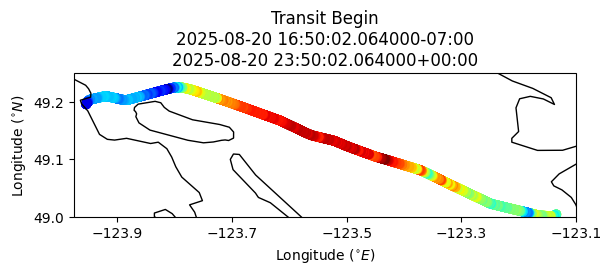

In [11]:
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True,subplot_kw = {'projection': crs})

ax.set_extent([-123.975,-123.1,49,49.25], crs = crs)
ax.coastlines()

ax.set_xticks(np.arange(-123.9,-123.1,0.2), crs = crs)
ax.set_yticks(np.arange(49,49.3,0.1), crs = crs)

ax.scatter(recent_transit.longitude, recent_transit.latitude, c = recent_transit.temperature, cmap = 'jet')
t_utc = pd.to_datetime(recent_transit.time.min().values).tz_localize('UTC')
t_local = t_utc.tz_convert('America/Vancouver')

ax.set_title(f"Transit Begin\n{t_local}\n{t_utc}")

ax.set_xlabel(r'Longitude ($^{\circ}E$)')
ax.set_ylabel(r'Longitude ($^{\circ}N$)')

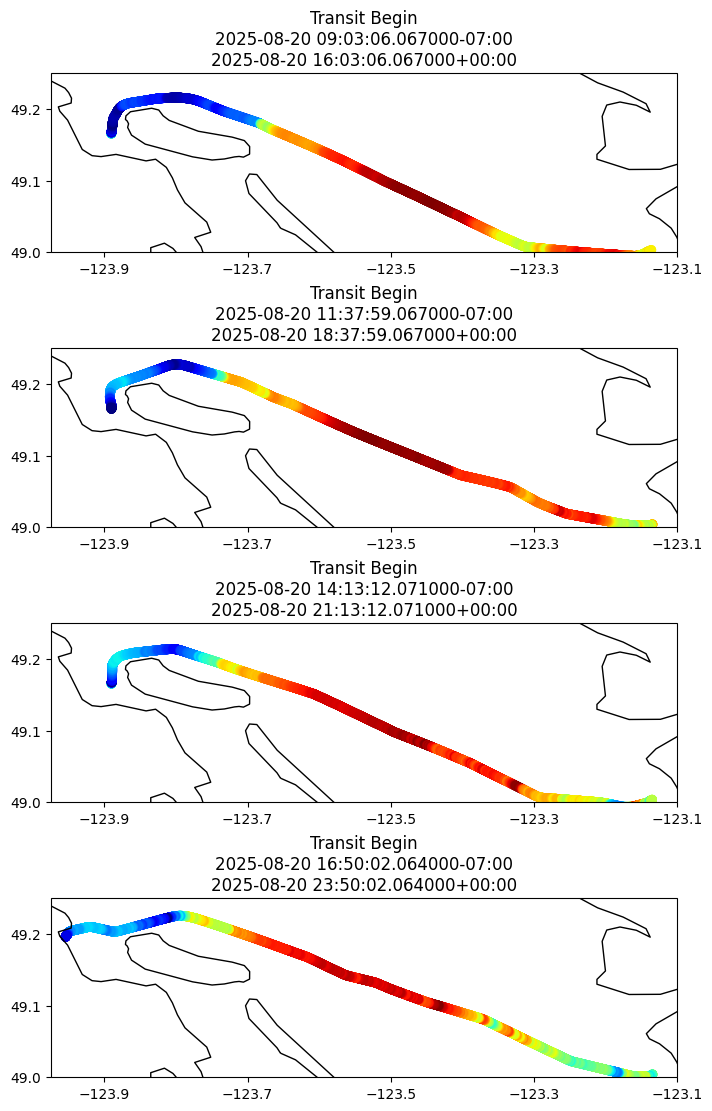

In [12]:
ncols = 1
nrows = len(transits)

fig, ax = plt.subplots(nrows,ncols, figsize = (14,11), constrained_layout = True,subplot_kw = {'projection': crs})

for i in range(nrows):
    ax[i].set_extent([-123.975,-123.1,49,49.25], crs = crs)
    ax[i].coastlines()

    ax[i].set_xticks(np.arange(-123.9,-123.1,0.2), crs = crs)
    ax[i].set_yticks(np.arange(49,49.3,0.1), crs = crs)

    ax[i].scatter(transits[i].longitude, transits[i].latitude, c = transits[i].temperature, cmap = 'jet')
    t_utc = pd.to_datetime(transits[i].time.min().values).tz_localize('UTC')
    t_local = t_utc.tz_convert('America/Vancouver')

    ax[i].set_title(f"Transit Begin\n{t_local}\n{t_utc}")

    # ax[i].set_xlabel(r'Longitude ($^{\circ}E$)')
    # ax[i].set_ylabel(r'Longitude ($^{\circ}N$)')